In [1]:
!pip install lmdb

In [2]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/workspace/20_ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/workspace/20_ocr/data/MJ/MJ_train


In [3]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

## data load

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


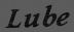

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


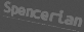

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


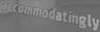

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


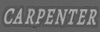

In [86]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH,
                max_readers=32,
                readonly=True,
                lock=False,
                readahead=False,
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))

        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)
        print('target_img_size:{}'.format(target_img_size))
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
        
        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [5]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self,
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :

        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]


    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)

    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size

            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)

    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    #
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

## Label encode decode

In [6]:
class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)



    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


## Model Setting

In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

In [10]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# Model fit

In [11]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
# ModelCheckPoint의 경우 'val_loss'를 모니터링하고 weight만 저장하는 옵션으로 지정해주세요.
# EarlyStopping도 'val_loss'를 모니터링해주세요.
# (EarlyStopping을 사용하지 않는 경우, model.fit()의 epoch 옵션을 20 정도로 설정해주세요.

checkpoint_path = './model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    verbose=1,
    mode="min",
    save_weights_only=True,
    )

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    verbose=1,
    mode="min",
    patience=5
    )


model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop]
)

Epoch 1/20
565/565 [==============================] - 136s 154ms/step - loss: 25.6597 - val_loss: 25.1563

Epoch 00001: saving model to ./model_checkpoint.hdf5
Epoch 2/20
565/565 [==============================] - 81s 144ms/step - loss: 16.2089 - val_loss: 10.4999

Epoch 00002: saving model to ./model_checkpoint.hdf5
Epoch 3/20
565/565 [==============================] - 81s 144ms/step - loss: 7.7096 - val_loss: 7.5456

Epoch 00003: saving model to ./model_checkpoint.hdf5
Epoch 4/20
565/565 [==============================] - 81s 144ms/step - loss: 5.4577 - val_loss: 5.7062

Epoch 00004: saving model to ./model_checkpoint.hdf5
Epoch 5/20
565/565 [==============================] - 81s 144ms/step - loss: 4.2975 - val_loss: 5.0437

Epoch 00005: saving model to ./model_checkpoint.hdf5
Epoch 6/20
565/565 [==============================] - 81s 144ms/step - loss: 3.5206 - val_loss: 4.6239

Epoch 00006: saving model to ./model_checkpoint.hdf5
Epoch 7/20
565/565 [==============================] -

# Inference

In [12]:
# checkpoint로 저장한 가중치 파일 불러오기
# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


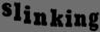

Result: 	 ALEPPO99999999999999999


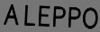

Result: 	 IFWENDA99999999999999999


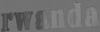

Result: 	 NATHANS99999999999999999


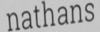

Result: 	 CHALLO99999999999999999


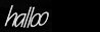

Result: 	 HURLS9999999999999999999


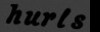

Result: 	 DOWNSIZE9999999999999999


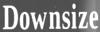

Result: 	 ROBOTIC99999999999999999


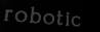

Result: 	 STOPPY99999999999999999


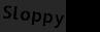

Result: 	 HERMITE99999999999999999


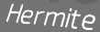

In [89]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

# End-to-End OCR
- [공식문서](https://keras-ocr.readthedocs.io/en/latest/index.html)

In [22]:
!pip install keras_ocr

In [15]:
import keras_ocr

SAMPLE_IMG_PATH = HOME_DIR + '/sample.jpg'

detector = keras_ocr.detection.Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [16]:
detector.model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
basenet.slice1.0 (Conv2D)       (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
basenet.slice1.1 (BatchNormaliz (None, None, None, 6 256         basenet.slice1.0[0][0]           
__________________________________________________________________________________________________
basenet.slice1.2 (Activation)   (None, None, None, 6 0           basenet.slice1.1[0][0]           
____________________________________________________________________________________________

In [108]:
from PIL import ImageDraw

def detect_text(img_path):
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    # 배치의 첫 번째 결과만 가져옵니다.
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)

    img = Image.open(img_path).convert('RGB')
    print('original image width:{}, height:{}'.format(img.size[0], img.size[1]))

    # 1. resize
    traget_img_size = (1000,600)
    resize_img = img.resize(traget_img_size)
    print('resize image width:{}, height:{}'.format(resize_img.size[0], resize_img.size[1]))

    # 원본 출력용으로 위해 다시 Image로
    result_img = resize_img
    # result이미지에 bbox그리는용도
    result_img_draw = ImageDraw.Draw(resize_img)

    # ocr용 img
    # 공식문서의 detect 의 parameter 보면
    # images – Can be a list of numpy arrays of shape HxWx3 or a list of filepaths. <- list형태의 HxWx3 np array를 전달

    ocr_img = np.array(resize_img)
    # ocr_img = np.expand_dims(ocr_img, axis=0)
    # print(ocr_img.shape)
    ocr_result = detector.detect([ocr_img])[0] # 배치의 첫 번째 결과 (input이미지가 1장이라 첫번째의 결과)
    cropped_imgs = []
    for text_result in ocr_result:
        result_img_draw.polygon(text_result, outline='red')
        x_min = text_result[:, 0].min() - 5
        x_max = text_result[:, 0].max() + 5
        y_min = text_result[:, 1].min() - 5
        y_max = text_result[:, 1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        # cropped_imgs.append(img_pil.crop(word_box))
        cropped_imgs.append(result_img.crop(word_box))


    return result_img, cropped_imgs

original image width:800, height:600
resize image width:1000, height:600


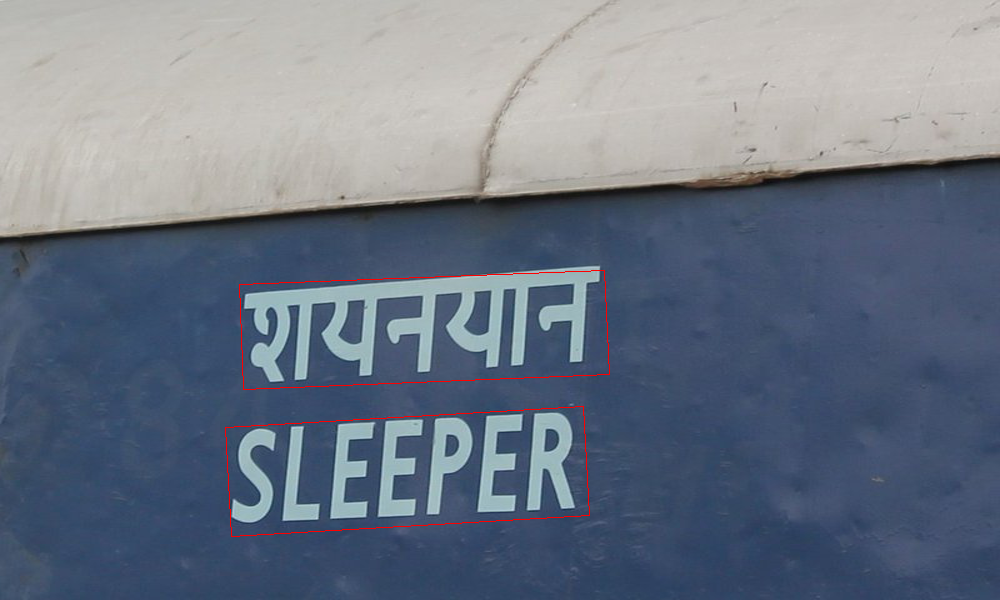

In [109]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

## CRNN recognizer

In [138]:
# CRNN recognizer
def crnn_recognize_img(model, pil_img, input_img_size=(100,32)):
    resize_pil_img = pil_img.resize(input_img_size)
    
    # crop된 이미지는 (32,100,3)HxWx3 이라
    # transpose로 (100,32,3)WxHx3로 변경
    pil_img = np.array(resize_pil_img, dtype=np.float32).transpose(1,0,2)
    # 배치차원 추가
    pil_img = np.expand_dims(pil_img, axis=0)

    output = model.predict(pil_img)
    result = decode_predict_ctc(
            output, chars="-"+TARGET_CHARACTERS)[0].replace('-', '')
    return resize_pil_img, result

<PIL.Image.Image image mode=RGB size=100x32 at 0x7BDDAD05A6D0>
result: TURUIA999999999999999999


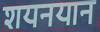

<PIL.Image.Image image mode=RGB size=100x32 at 0x7BDDAD329D90>
result: SLEEPER9999999999999999


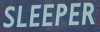

In [96]:
for _img in cropped_img:
    result_img, pred = crnn_recognize_img(model_pred, _img)
    print('result:', pred)
    display(result_img)

## keras-ocr recognizer

In [100]:
# keras-ocr recognizer
def keras_recognize_img(model, pil_img, input_img_size=(100,32)):
    resize_pil_img = pil_img.resize(input_img_size)
    pil_img = np.array(resize_pil_img)
    return resize_pil_img, model.recognize(pil_img)

Looking for /aiffel/.keras-ocr/crnn_kurapan.h5
result: tatt


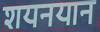

result: sleeper


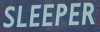

In [101]:
keras_recognizer = keras_ocr.recognition.Recognizer()

for _img in cropped_img:
    result_img, pred = keras_recognize_img(keras_recognizer,_img)
    print('result:', pred)
    display(result_img)

# 다른이미지 테스트

original image width:640, height:480
resize image width:1000, height:600


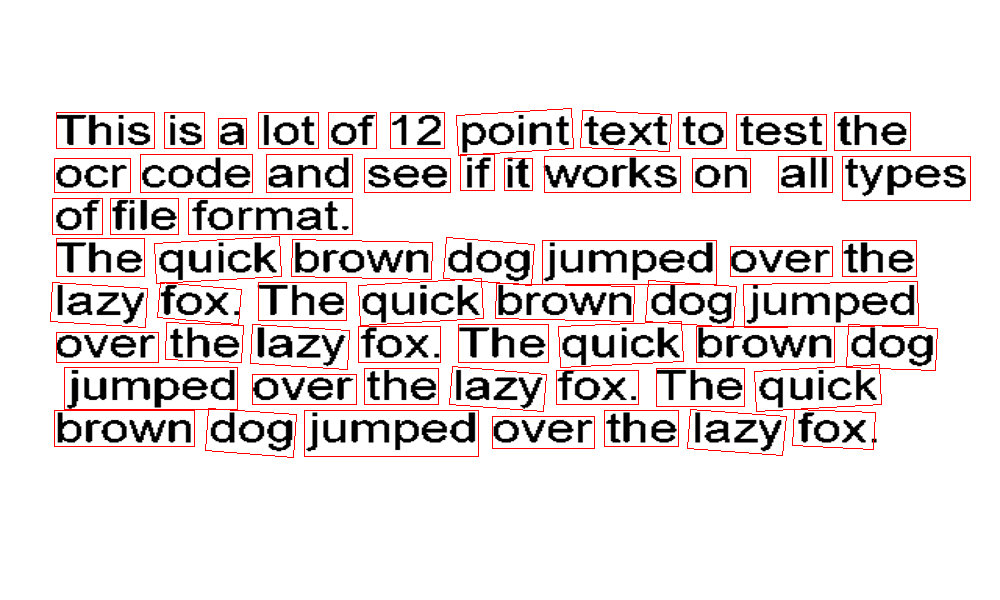

result: THIS


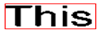

result: LIESY


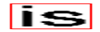

result: IOTL


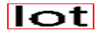

result: HOIFI


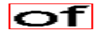

result: I


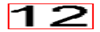

result: IPOINT


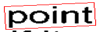

result: TEXT


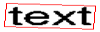

result: ICMY


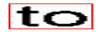

result: HTHAL


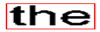

result: TEST


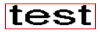

result: ESNY


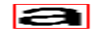

result: ICODE


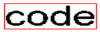

result: AML


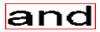

result: TIRY


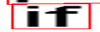

result: IANRY


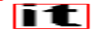

result: IORKS


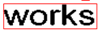

result: LEALILY


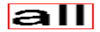

result: ITYPAS


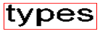

result: KOR


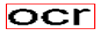

result: LSEL


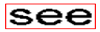

result: ICOML


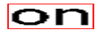

result: HOIFI


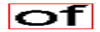

result: IFILEA


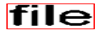

result: FORMATI


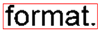

result: THEL


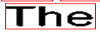

result: IQUICK


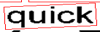

result: IBROWN


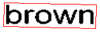

result: ICOGY


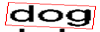

result: JUMPED


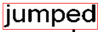

result: ITAL


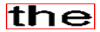

result: OVEM


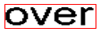

result: IFOY


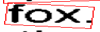

result: THAL


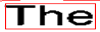

result: IQUICK


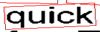

result: LOST


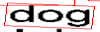

result: JUMPED


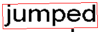

result: LAZY


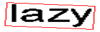

result: IBROWN


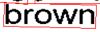

result: HTHEAL


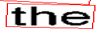

result: NTHEL


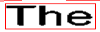

result: IQUICK


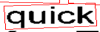

result: LAZY


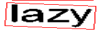

result: IO


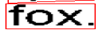

result: BROWN


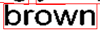

result: IDIOA


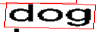

result: OVER


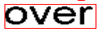

result: JUMPED


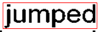

result: ITMEL


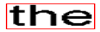

result: LAZY


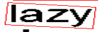

result: FO


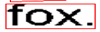

result: THE


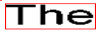

result: QUICK


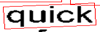

result: OVEN


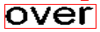

result: BROWN


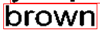

result: LDOG


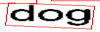

result: JUMPED


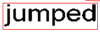

result: ITAEL


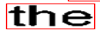

result: HFODY


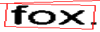

result: ILAZY


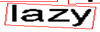

result: OVEN


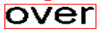

In [142]:
TEST_IMG_PATH = './img_only_text.png'
img_pil, cropped_img = detect_text(TEST_IMG_PATH)
display(img_pil)

for _img in cropped_img:
    result_img, pred = crnn_recognize_img(model_pred, _img)
    print('result:', pred.replace('9',''))
    display(result_img)

original image width:626, height:580
resize image width:1000, height:600


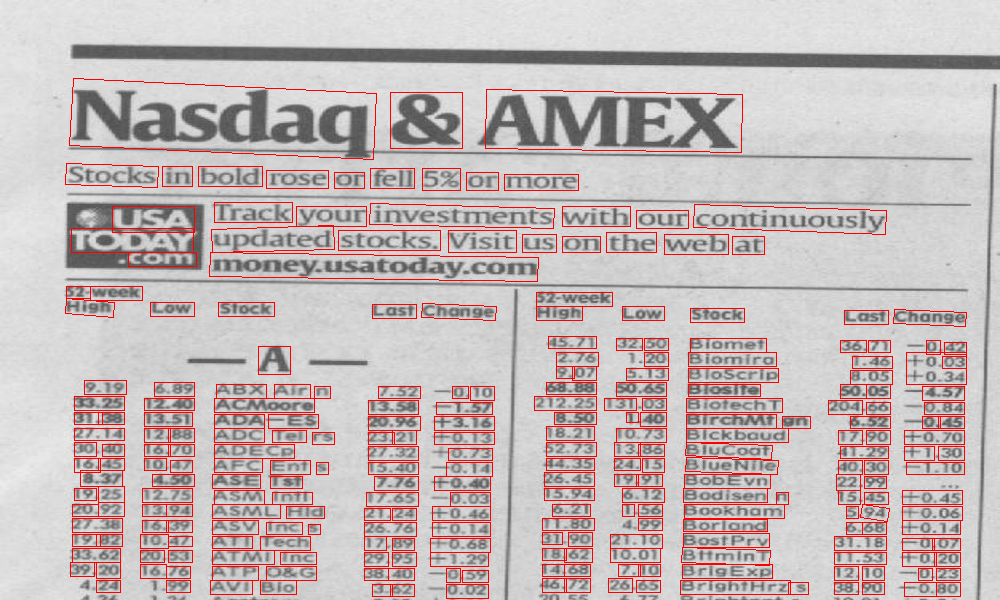

result: NASDAG


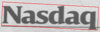

result: LATAS


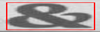

result: AMIEX


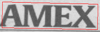

result: SPORS


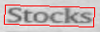

result: UIDZNY


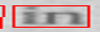

result: EDY


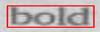

result: ERSM


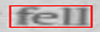

result: ESDY


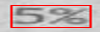

result: AIDPASRY


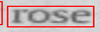

result: EDRN


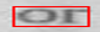

result: SOPRY


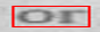

result: MOME


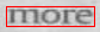

result: MER


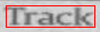

result: TMVESTMENTS


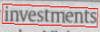

result: CHUSHY


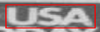

result: NEIOUDY


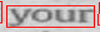

result: FAITEY


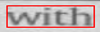

result: CONTIMOISY


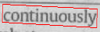

result: SPR


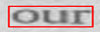

result: TCIEAY


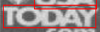

result: FOPDATED


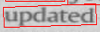

result: GORSY


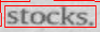

result: UTDY


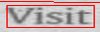

result: AED


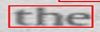

result: PRSY


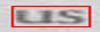

result: NTEDEY


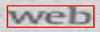

result: VEOOI


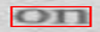

result: JIOPSOEY


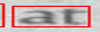

result: MEORIG


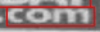

result: MOLDNDONONT


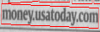

result: ARSRORAGY


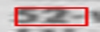

result: GNOEAR


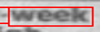

result: RAEN


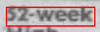

result: SENRIAONST


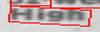

result: INOOD


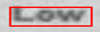

result: JEAR


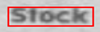

result: ROR


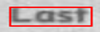

result: BNORY


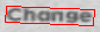

result: CAMADY


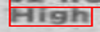

result: IMRARD


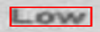

result: EDACR


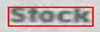

result: ROY


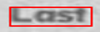

result: ENANERG


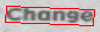

result: NOZIN


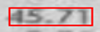

result: RG


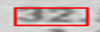

result: INPARML


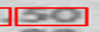

result: RIOMEY


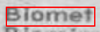

result: RMRIG


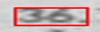

result: AOMG


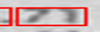

result: AREOG


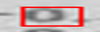

result: GEMANGL


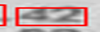

result: DPCONY


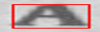

result: AES


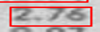

result: NERNDEY


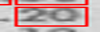

result: EMGARD


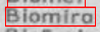

result: EAN


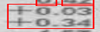

result: IMRE


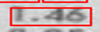

result: TIODERASY


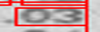

result: AESIMNG


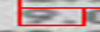

result: MCAD


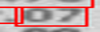

result: EY


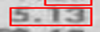

result: RTASIOITY


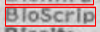

result: ADEY


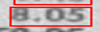

result: ERY


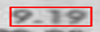

result: OERY


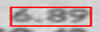

result: EITIORY


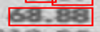

result: ELDZEY


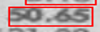

result: AME


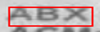

result: SMAY


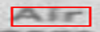

result: EIOPETIY


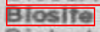

result: RTDRS


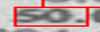

result: MCMSYT


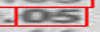

result: GRG


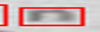

result: APR


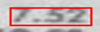

result: ANOG


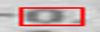

result: AMNCYL


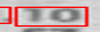

result: EUEDY


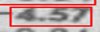

result: PUDINY


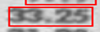

result: PIIDENY


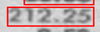

result: PRITY


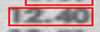

result: ACMBOND


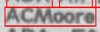

result: ISTITI


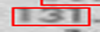

result: MOEUERY


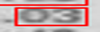

result: RIDTROHG


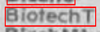

result: DUNY


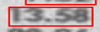

result: MADOET


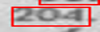

result: RINDT


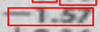

result: HSAREY


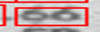

result: EMY


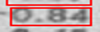

result: EMOUY


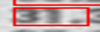

result: TICSORY


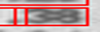

result: TEUNTY


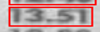

result: TERUEOY


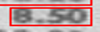

result: MRMIRLS


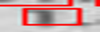

result: MAESY


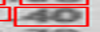

result: DMDEY


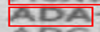

result: INSDSENST


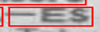

result: GEPONDINY


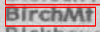

result: TOMREY


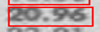

result: HEMNTINY


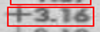

result: RPOPRY


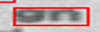

result: PERNDEY


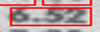

result: PLODMD


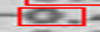

result: TRDARUSY


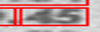

result: PEMPINY


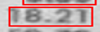

result: IAINY


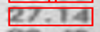

result: IST


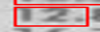

result: WDOMESY


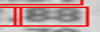

result: EAOY


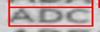

result: MOAIZEY


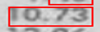

result: ECRBCINIGY


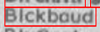

result: TATINT


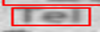

result: MROET


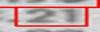

result: MIZET


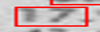

result: TEADEAY


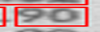

result: RAOIZINY


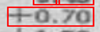

result: RSOMEG


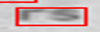

result: PONTOIG


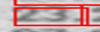

result: HDINY


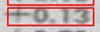

result: EADOT


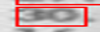

result: SMITY


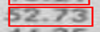

result: IOMOS


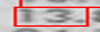

result: REISTIG


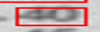

result: IUEMY


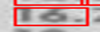

result: TIPORY


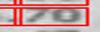

result: AEMIATY


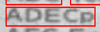

result: DIERUSY


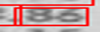

result: EMPBOABIOG


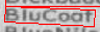

result: INDY


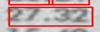

result: TID


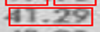

result: EATIT


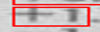

result: TBANDSY


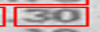

result: TUMES


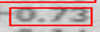

result: ITES


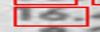

result: TIERAUEY


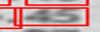

result: IMOATNY


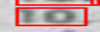

result: NBOEY


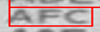

result: SEY


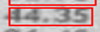

result: ZEDAMYT


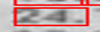

result: SATDUEY


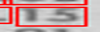

result: EMANIGS


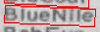

result: FIESMNGL


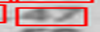

result: TUTERY


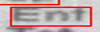

result: EDAT


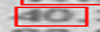

result: TEADESY


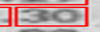

result: ARGNG


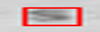

result: IUORY


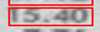

result: OMEY


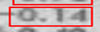

result: TMIRY


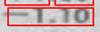

result: AEMINRY


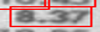

result: TRDEY


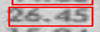

result: HRIUSO


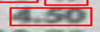

result: AMEIMEY


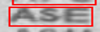

result: IESIY


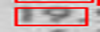

result: SAUESOMY


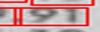

result: EOBRAUNY


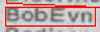

result: APUTINT


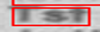

result: IEY


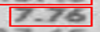

result: ACAMRY


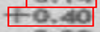

result: BRUENMS


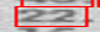

result: GREORANEY


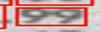

result: NOUEINT


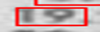

result: MBAMEY


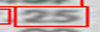

result: DUMNY


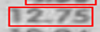

result: TUHY


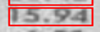

result: TEMIDY


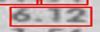

result: FEOCBRAY


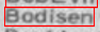

result: SHUDO


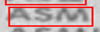

result: RAGS


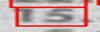

result: RAOME


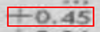

result: ISI


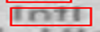

result: IENY


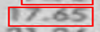

result: TEDEY


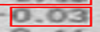

result: ARGN


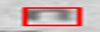

result: GHESMRES


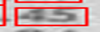

result: YECORY


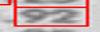

result: TAGING


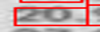

result: TAT


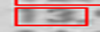

result: TOETMY


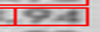

result: HASMID


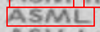

result: ERSZING


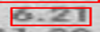

result: AITHUD


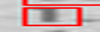

result: TBEOUSY


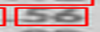

result: HORHGING


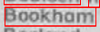

result: EOIEN


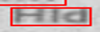

result: RAOMR


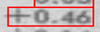

result: MIRBOUSEN


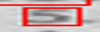

result: MLSPOSTNES


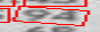

result: DODEY


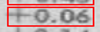

result: TROYT


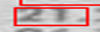

result: MEROMNY


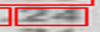

result: TMONY


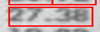

result: IENY


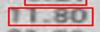

result: AISOUSSY


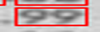

result: LIRYS


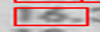

result: SIGREDINY


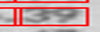

result: SCEITDY


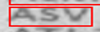

result: SUPIEIRY


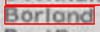

result: RMOSIN


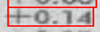

result: LTESY


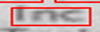

result: ZRDEY


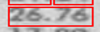

result: UDIDY


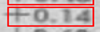

result: IERUS


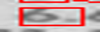

result: GAOSEY


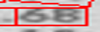

result: ARMON


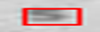

result: ACEMIOTE


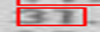

result: EODESY


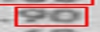

result: TUSPTOYG


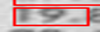

result: HIEUDEY


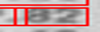

result: IMT


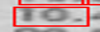

result: AMIRY


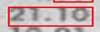

result: BIUITHINY


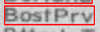

result: MHAZZG


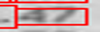

result: DTMY


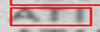

result: LDAELY


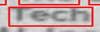

result: ANOMAGE


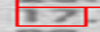

result: EIMINEY


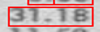

result: DTERAEBLY


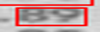

result: UMDZERY


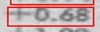

result: RMAUIY


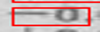

result: TNGEY


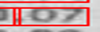

result: ERUDY


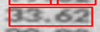

result: IRENS


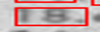

result: SEDY


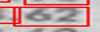

result: DCUONY


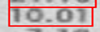

result: EMAIGNGS


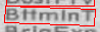

result: AUT


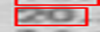

result: THESHIENY


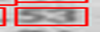

result: ULY


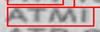

result: IAOE


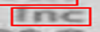

result: COUSNGH


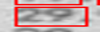

result: CTEOUESY


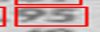

result: RAMRY


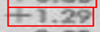

result: TUNY


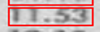

result: UANDLY


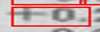

result: MIDEDEY


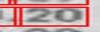

result: AROCNGS


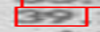

result: MBAEY


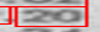

result: IDAG


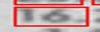

result: IUABTGY


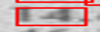

result: SIUOUEY


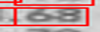

result: TIEPMNT


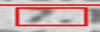

result: YIONG


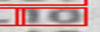

result: EAGERD


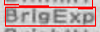

result: MEY


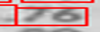

result: SEMEY


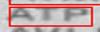

result: FONIDY


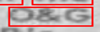

result: DELT


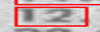

result: TEY


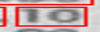

result: BRUETYIN


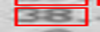

result: TIUEONY


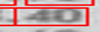

result: PNH


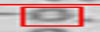

result: WNOROGHS


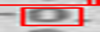

result: HIEERORY


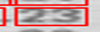

result: WNSESNY


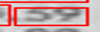

result: ET


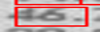

result: WZERY


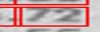

result: MUOTY


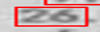

result: SIENRMY


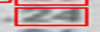

result: MIERUAPERY


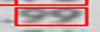

result: EOY


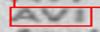

result: SETOMEST


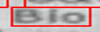

result: HBSRY


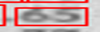

result: EPDNOARG


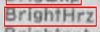

result: PINSEG


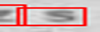

result: BRERYN


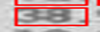

result: JTEOROTG


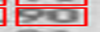

result: SIMAISY


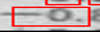

result: SERYL


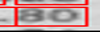

result: KGMALIG


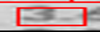

result: SUEESINGL


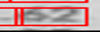

result: ATATY


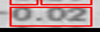

In [143]:
TEST_IMG_PATH = './img_news.jpg'
img_pil, cropped_img = detect_text(TEST_IMG_PATH)
display(img_pil)
for _img in cropped_img:
    result_img, pred = crnn_recognize_img(model_pred, _img)
    print('result:', pred.replace('9',''))
    display(result_img)

# 회고
- 배운점
    - ocr의 recognizer를 CRNN 기반으로 구현, keras_ocr의 craft detect 사용법
- 아쉬운점
    - 좀더 다양한 이미지에서 테스트해보니 인식이 제대로 안되는경우가 많았다.
- 느낀점
    - 직접 구현 및 이해하려고 하니 평상시에 생각했던것보다 ocr은 복잡한 구조를 가지며 어려웠다.
- 어려운점
    - detect, recognize 하는 과정을 이해하는게 어려웠다